In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances

In [2]:
# Parameters
n = 2500
random.seed(1)
u = np.random.rand(n, 2)

# Parametric equations
v = 3 * np.pi / 2 * (0.1 + 2 * u[:, 0])
x = -np.cos(v) * v
y = 20 * u[:, 1]
z = np.sin(v) * v

# Combine the data into a single matrix
swissroll = np.column_stack((x, y, z))

# Calcul de la matrice des distances (euclidienne)
D = pairwise_distances(swissroll)

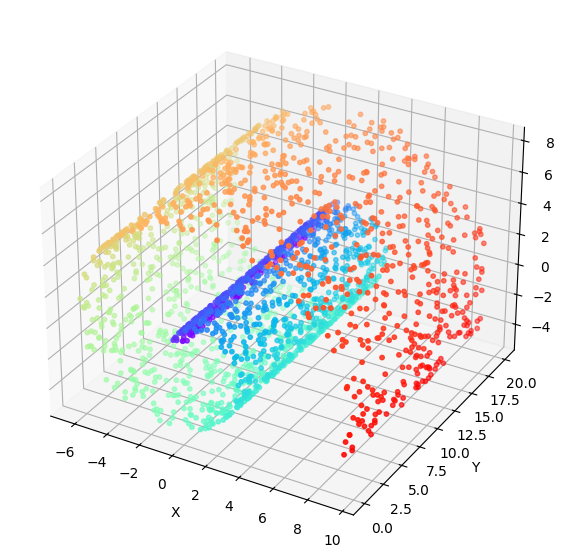

In [3]:
# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Sort by v to make it look smooth, and color by v
idx = np.argsort(v)
ax.scatter(
    swissroll[idx, 0],
    swissroll[idx, 1],
    swissroll[idx, 2],
    c=v[idx],
    cmap="rainbow",
    s=10,
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [4]:
# Fonction MDS classique
def monMDS(D, p_prime):
    """
    Implémente le MDS classique pour réduire une matrice des distances à un espace de dimension p_prime.

    Arguments :
    - D : matrice des distances.
    - p_prime : nombre de dimensions cibles.

    Retourne :
    - Les coordonnées des points dans l'espace de dimension réduite.
    """

    # Récupérer la taille de la matrice D (nombre de points)
    N = D.shape[0]

    # Créer un vecteur colonne rempli de 1 (taille N x 1)
    ones = np.ones((N, 1))

    # Calculer le produit ones @ ones.T, ce qui donne une matrice N x N remplie de 1
    onesTimesOnesT = ones @ ones.T

    # Calcul de la matrice B des produits scalaires centrés
    # B est construite en utilisant la matrice de distances D et le centrage des données
    B = -0.5 * (
        D
        - (1 / N) * np.dot(D, onesTimesOnesT)  # Centrage par rapport aux lignes
        - (1 / N) * np.dot(onesTimesOnesT, D)  # Centrage par rapport aux colonnes
        + (1 / N**2)
        * np.dot(onesTimesOnesT, np.dot(D, onesTimesOnesT))  # Double centrage
    )

    # Calcul des valeurs propres (eigvals) et des vecteurs propres (eigvecs) de la matrice B
    eigvals, eigvecs = np.linalg.eigh(B)

    # Trier les valeurs propres en ordre décroissant
    idx = np.argsort(eigvals)[
        ::-1
    ]  # Indices pour trier les valeurs dans l'ordre décroissant
    eigvals = eigvals[idx]  # Trier les valeurs propres
    eigvecs = eigvecs[:, idx]  # Trier les vecteurs propres en conséquence

    # Sélectionner les p' plus grandes valeurs propres (racine carrée des valeurs propres)
    L_p = np.diag(np.sqrt(eigvals[:p_prime]))

    # Sélectionner les p' premiers vecteurs propres associés
    V_p = eigvecs[:, :p_prime]

    # Calculer les coordonnées des points dans l'espace réduit en multipliant V_p par L_p
    X_p = np.dot(V_p, L_p)

    # Retourner les coordonnées des points dans l'espace de dimension réduite
    return X_p

In [5]:
# Appliquer MDS pour réduire à 2 dimensions
X_2D = monMDS(D, 2)

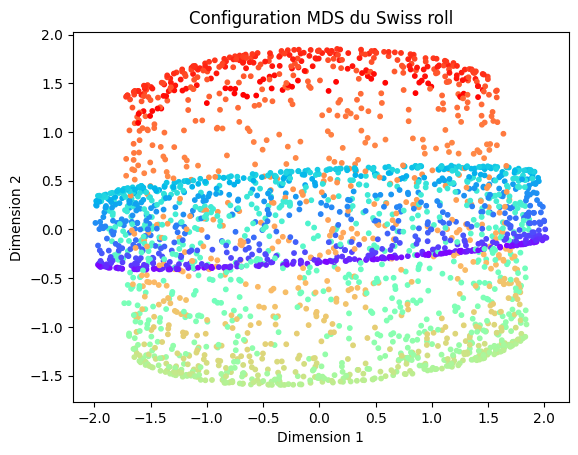

In [6]:
# Visualisation des points projetés en 2D
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=v, cmap="rainbow", s=10)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Configuration MDS du Swiss roll")
plt.show()

In [7]:
def examiner_valeurs_propres(D, seuil_variance=0.9):
    """
    Extrait et examine les valeurs propres de la décomposition spectrale et calcule
    combien de dimensions sont nécessaires pour expliquer un certain pourcentage de variance.

    Arguments :
    - D : matrice des distances.
    - seuil_variance : le pourcentage de variance à expliquer (par défaut 90%).

    Retourne :
    - Les valeurs propres triées.
    - Le nombre de dimensions nécessaires pour expliquer la variance spécifiée.
    """
    N = D.shape[0]
    ones = np.ones((N, 1))
    onesTimesOnesT = ones @ ones.T
    B = -0.5 * (
        D
        - (1 / N) * np.dot(D, onesTimesOnesT)
        - (1 / N) * np.dot(onesTimesOnesT, D)
        + (1 / N**2) * np.dot(onesTimesOnesT, np.dot(D, onesTimesOnesT))
    )
    eigvals, _ = np.linalg.eigh(B)

    # Trier les valeurs propres en ordre décroissant
    eigvals = np.sort(eigvals)[::-1]

    # Normaliser les valeurs propres pour obtenir la variance expliquée
    var_expliquee = eigvals / np.sum(eigvals)

    # Calculer la variance expliquée cumulative
    var_expliquee_cumulative = np.cumsum(var_expliquee)

    # Déterminer combien de dimensions sont nécessaires pour atteindre le seuil de variance
    n_dimensions = np.argmax(var_expliquee_cumulative >= seuil_variance) + 1

    # Tracer la variance expliquée cumulative
    plt.figure(figsize=(8, 6))
    plt.plot(var_expliquee_cumulative, marker="o")
    plt.axhline(y=seuil_variance, color='r', linestyle='--')
    plt.title(f"Variance expliquée cumulative (Seuil = {seuil_variance*100:.0f}%)")
    plt.xlabel("Dimensions")
    plt.ylabel("Variance expliquée cumulative")
    plt.grid(True)
    plt.show()

    print(f"Nombre de dimensions nécessaires pour expliquer {seuil_variance*100:.0f}% de la variance : {n_dimensions}")

    return eigvals, n_dimensions


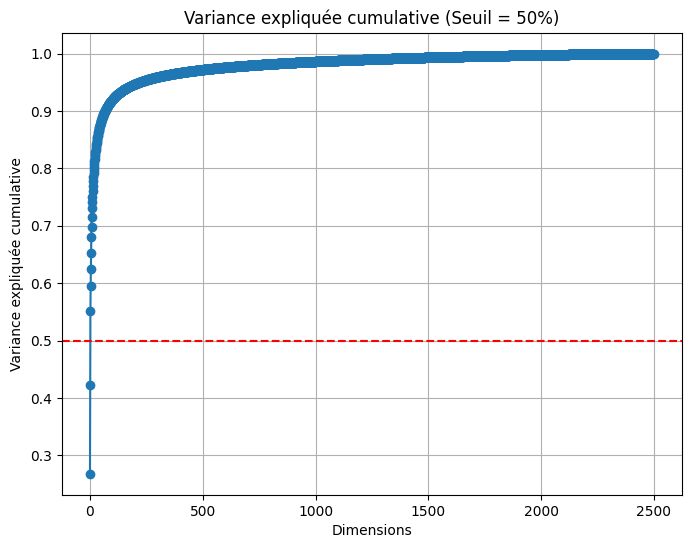

Nombre de dimensions nécessaires pour expliquer 50% de la variance : 3


In [8]:
# Appliquer la fonction sur la matrice des distances D
eigvals, n_dimensions = examiner_valeurs_propres(D, seuil_variance=0.5)